In [1]:
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import matplotlib.pylab as plt
%matplotlib inline

import seaborn as sns
from scipy import signal

In [2]:
trainDF = pd.read_csv('../data/train.csv')
testDF = pd.read_csv('../data/test.csv')

In [3]:
trainDF.describe()

,row_id,x,y,accuracy,time,place_id
count,2.911802e+07,2.911802e+07,2.911802e+07,2.911802e+07,2.911802e+07,2.911802e+07
mean,1.455901e+07,4.999770e+00,5.001814e+00,8.284912e+01,4.170104e+05,5.493787e+09
std,8.405649e+06,2.857601e+00,2.887505e+00,1.147518e+02,2.311761e+05,2.611088e+09
min,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000016e+09
25%,7.279505e+06,2.534700e+00,2.496700e+00,2.700000e+01,2.030570e+05,3.222911e+09
50%,1.455901e+07,5.009100e+00,4.988300e+00,6.200000e+01,4.339220e+05,5.518573e+09
75%,2.183852e+07,7.461400e+00,7.510300e+00,7.500000e+01,6.204910e+05,7.764307e+09
max,2.911802e+07,1.000000e+01,1.000000e+01,1.033000e+03,7.862390e+05,9.999932e+09


In [4]:
trainDF.head()

,row_id,x,y,accuracy,time,place_id
0,0,0.7941,9.0809,54,470702,8523065625
1,1,5.9567,4.7968,13,186555,1757726713
2,2,8.3078,7.0407,74,322648,1137537235
3,3,7.3665,2.5165,65,704587,6567393236
4,4,4.0961,1.1307,31,472130,7440663949


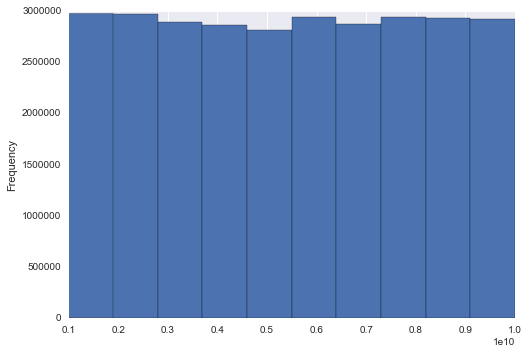

In [5]:
trainDF['place_id'].plot(kind='hist')

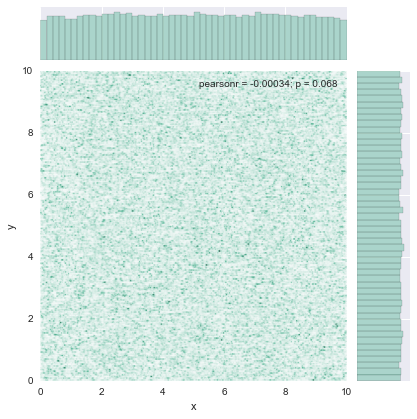

In [6]:
sns.jointplot(trainDF['x'], trainDF['y'], kind="hex", color="#4CB391")

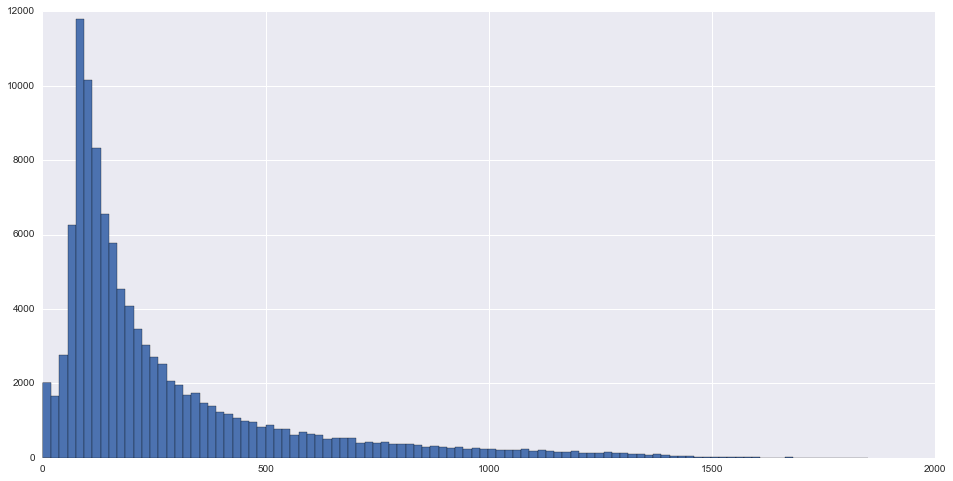

In [7]:
trainDF.groupby('place_id').size().hist(bins=100, figsize=(16,8))

In [8]:
highest_place_ids = trainDF.groupby('place_id').size().sort_values(ascending=False)[:20].index

highestDF = trainDF[trainDF['place_id'].isin(highest_place_ids)]

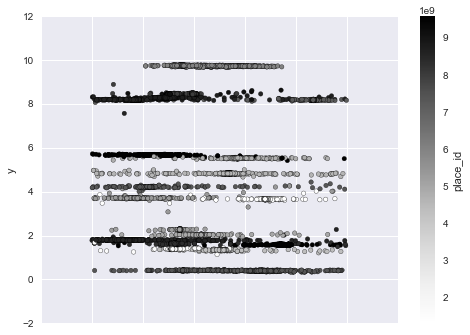

In [9]:
highestDF.plot(x='x', y='y', kind='scatter', c='place_id')

(0, 10)

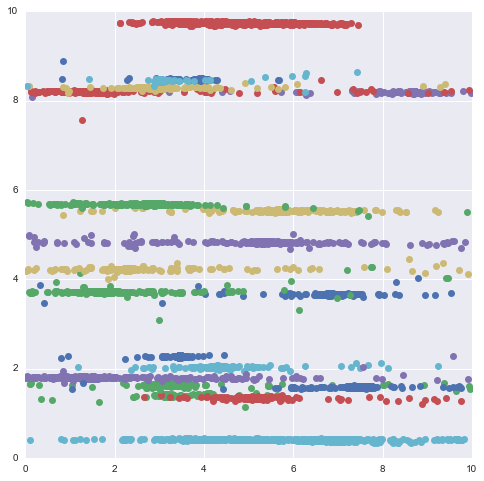

In [10]:
fig, ax = plt.subplots(1,1, figsize=(8,8))

for place_id, group in highestDF.groupby('place_id'):
    ax.plot(group['x'], group['y'], 'o')
plt.ylim([0,10])

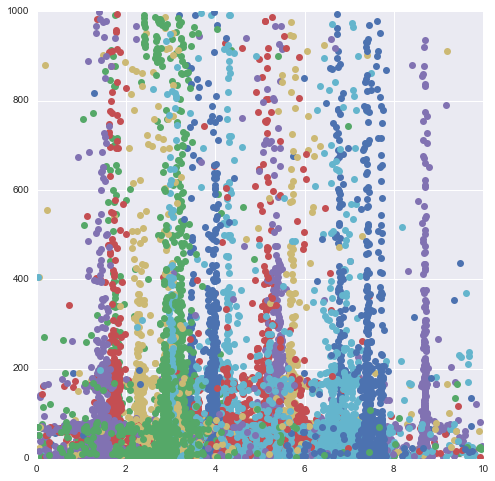

In [11]:
fig, ax = plt.subplots(1,1, figsize=(8,8))

for place_id, group in highestDF.groupby('place_id'):
    ax.plot(group['x'], group['accuracy'], 'o')
# plt.ylim([0,10])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0b0db41d50>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f0b0d902590>]], dtype=object)

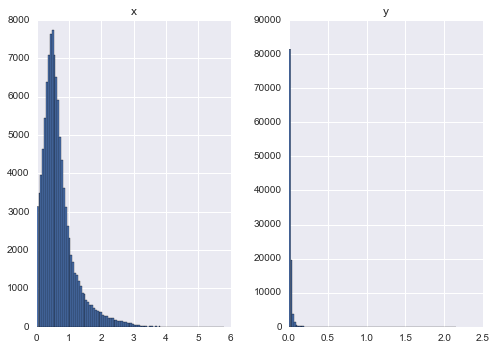

In [12]:
placed_group = trainDF.groupby('place_id')
placed_group[['x','y']].std().hist(bins=100)

The accuracy seems to be independant of the x and y position:

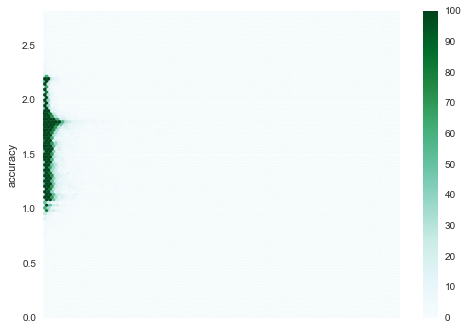

In [13]:
stdx_med_df = pd.concat([placed_group['y'].std(), np.log10(placed_group['accuracy'].median())], axis=1)
stdx_med_df.plot.hexbin('y','accuracy',vmax=100)

In [15]:
# trainDF.plot.hexbin('x','y',C='accuracy',reduce_C_function=np.mean)

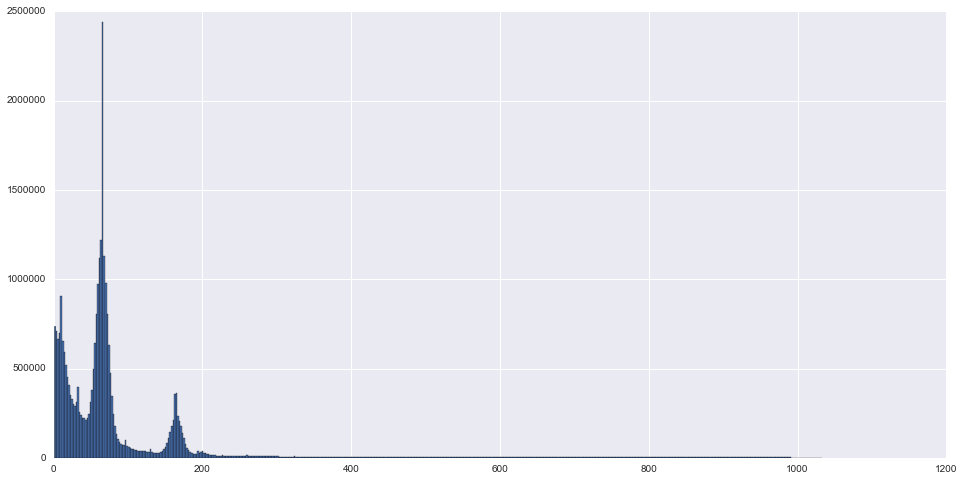

In [16]:
trainDF['accuracy'].hist(bins=500, figsize=(16,8))

Accuracy is probably a measure of error.

It looks like there are three types (low, mid, high).

This might correspond to discrete accuracy settings on a GPS chip, etc.

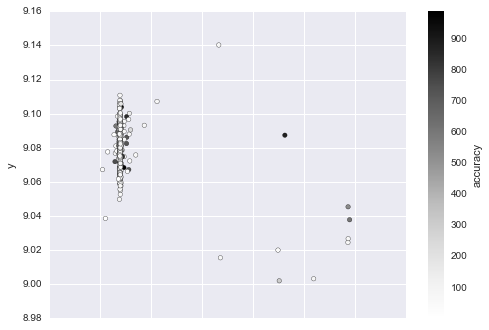

In [17]:
placed_group.get_group(8523065625).plot(x='x', y='y', kind='scatter', c='accuracy')

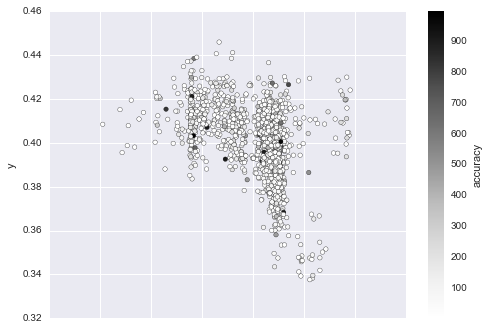

In [18]:
placed_group.get_group(highest_place_ids[11]).plot(x='x', y='y', kind='scatter', c='accuracy')

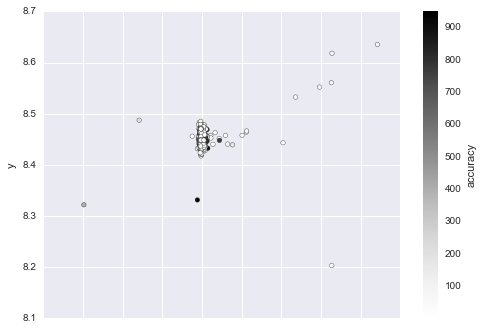

In [19]:
trainDF[trainDF['place_id'] == highest_place_ids[5]].plot(x='x', y='y', kind='scatter', c='accuracy')
# plt.ylim([0,10])

### Accuracy vs. Distance from centroid

In [20]:
# centroid_df = placed_group.apply(lambda df: Series({'x_mean': df['x'].mean(), 'y_mean': df['y'].mean()}))

def dist_from_centroid(df):
    x = (df['x'] - centroid_df.ix[df['place_id']]['x_mean'])**2
    y = (df['y'] - centroid_df.ix[df['place_id']]['y_mean'])**2
    dist = np.sqrt(x+y)
    
    return dist

dist_df = trainDF.iloc[:100000].apply(dist_from_centroid, axis=1) #, args=centroid_df) trainDF['x_dist_centroid'] = 

NameError: ("global name 'centroid_df' is not defined", u'occurred at index 0')

In [21]:
dist_df2 = pd.concat([trainDF.iloc[:100000],DataFrame(dist_df,columns=['dist'])], axis=1)
dist_df2.plot.hexbin(x='dist',y='accuracy',vmax=10)

NameError: name 'dist_df' is not defined

In [22]:
dist_df2

NameError: name 'dist_df2' is not defined

### Looking at time

(500000, 650000)

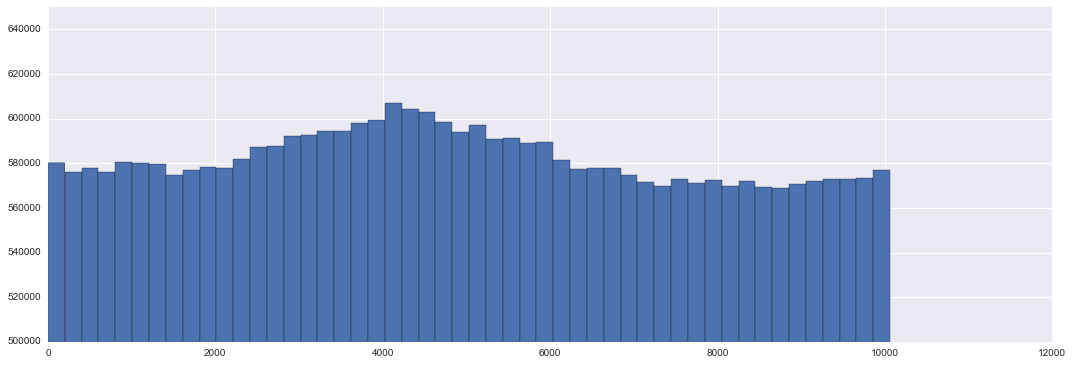

In [23]:
(trainDF['time']%(10063.)).hist(bins=50, figsize=(18,6))
plt.ylim([500000,650000])

In [24]:
usage_count, usage_time = np.histogram(trainDF['time'], bins=2500)
usage_time = usage_time[:-1]

In [25]:
fs = 1./(usage_time[1] - usage_time[0])
print fs

0.00317969876806


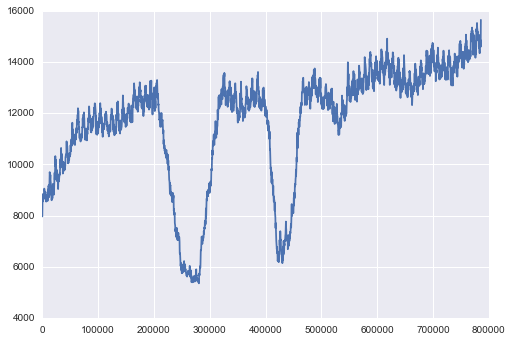

In [26]:
plt.plot(usage_time, usage_count)

In [27]:
f, Pxx_den = signal.welch(usage_count - np.mean(usage_count), fs, nperseg=256)

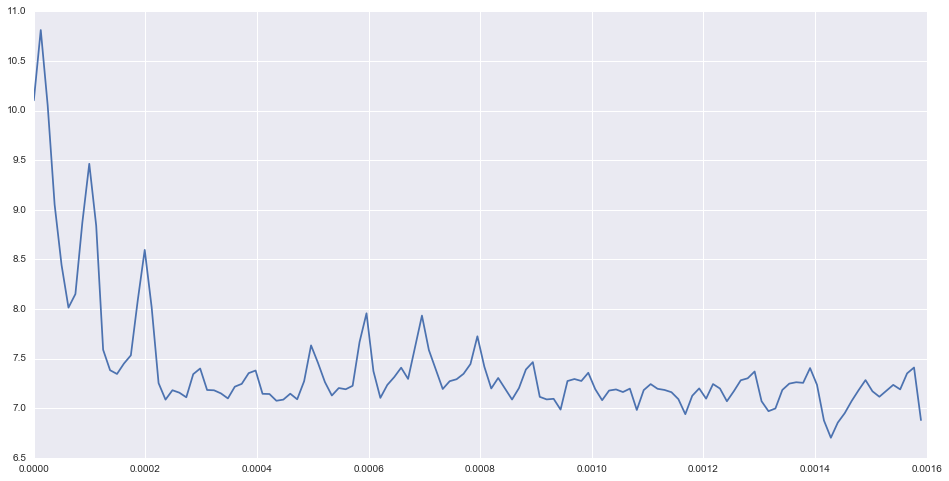

In [28]:
plt.figure(figsize=(16,8))
plt.plot(f, np.log10(Pxx_den))

In [29]:
psd = Series(Pxx_den)
f_day = f[psd[f > 0.00015].idxmax()]
f_week = f[psd[f > 0.00005].idxmax()]

In [30]:
print 1/f_day

5031.9232


A day is 10,063 units.

In [31]:
60*24

1440

In [32]:
sorted_time = trainDF.sort_values(by='time')['time']

In [33]:
trainDF['ctime'] = trainDF['time'] % 10063.

# Top Places Model
Build model using only the top 1000 places.

In [37]:
len(trainDF)

29118021

In [55]:
placed_group.size().sort_values(ascending=False)[:500].sum()

730158

In [56]:
# top_places = trainDF[trainDF['place_id'].isin(placed_group.size().sort_values(ascending=False)[:1000].index)]
top_places = placed_group.size().sort_values(ascending=False)[:500].index

In [42]:
trainDF.columns.values

array(['row_id', 'x', 'y', 'accuracy', 'time', 'place_id', 'ctime'], dtype=object)

TODO: Use a weighted scaler by placeid group size

In [84]:
# placed_group.apply(lambda df: df['x'].std() * len(df)).mean() / float(len(trainDF))
x_std_mean = placed_group['x'].std().mean()
y_std_mean = placed_group['y'].std().mean()
print x_std_mean, y_std_mean
trainDF['x_std']  = trainDF['x'] / x_std_mean
trainDF['y_std']  = trainDF['y'] / y_std_mean
trainDF['ctime_std'] = trainDF['ctime'] / trainDF['ctime'].max()

0.680755561936 0.0208191008939


(-2.0, 10.0, 8.1500000000000004, 8.4500000000000011)

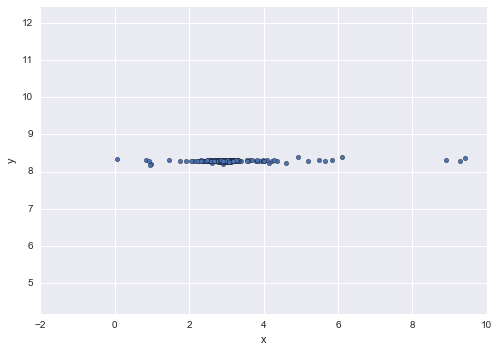

In [83]:
trainDF[trainDF['place_id'] == highest_place_ids[0]].plot(x='x_std', y='y_std', kind='scatter')
plt.axis('equal')

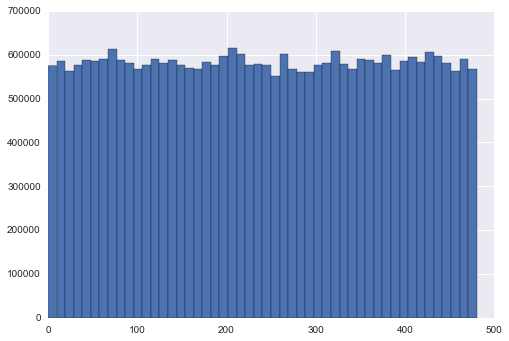

In [77]:
trainDF['y_std'].hist(bins=50)

In [85]:
from sklearn.cross_validation import train_test_split
ml_cols = ['x_std', 'y_std', 'ctime_std']
X = trainDF[ml_cols]
y = trainDF['place_id']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [86]:
X_train_top = X_train.ix[y_train.isin(top_places)]
y_train_top = y_train.ix[y_train.isin(top_places)]

In [89]:
from sklearn.neighbors import KNeighborsClassifier
nbrs = KNeighborsClassifier(n_neighbors=25).fit(X_train_top, y_train_top)

In [90]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, nbrs.predict(X_test))

0.023598943776045388

# Training Grid KNN

In [91]:
trainDF[trainDF['x'] > 5]

,row_id,x,y,accuracy,time,place_id,ctime,x_std,y_std,ctime_std
1,1,5.9567,4.7968,13,186555,1757726713,5421.0,8.750130,230.403802,0.538760
2,2,8.3078,7.0407,74,322648,1137537235,632.0,12.203793,338.184633,0.062811
3,3,7.3665,2.5165,65,704587,6567393236,177.0,10.821065,120.874576,0.017591
6,6,6.3336,4.3720,13,666829,9931249544,2671.0,9.303780,209.999463,0.265454
7,7,5.7409,6.7697,85,369002,5662813655,6734.0,8.433130,325.167741,0.669251
9,9,6.3414,0.0758,65,400060,1253803156,7603.0,9.315238,3.640887,0.755615
11,11,8.7101,2.9442,73,153493,2159916487,2548.0,12.794754,141.418211,0.253230
14,14,6.1550,1.9774,8,325411,2272949794,3395.0,9.041424,94.980086,0.337408
15,15,7.6219,9.6208,65,321519,4740742194,9566.0,11.196236,462.114097,0.950706
20,20,5.3298,6.3457,52,736113,4845908305,1514.0,7.829242,304.801828,0.150467
